In [1]:
import sys
import random 
import numpy as np
import correction
import emip_toolkit as EMTK 
import numpy as np
import drift_algorithms as algo
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import Image
img = Image(filename= 'synthetic_text.png')

In [3]:
image_path = ""
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")
aoi.head()

,kind,name,x,y,width,height,image
0,sub-line,line 1 part 1,626.5,5,63,32,synthetic_text.png
1,sub-line,line 1 part 2,692.5,5,146,32,synthetic_text.png
2,sub-line,line 1 part 3,841.5,5,117,32,synthetic_text.png
3,sub-line,line 1 part 4,960.5,5,65,32,synthetic_text.png
4,sub-line,line 1 part 5,1026.5,5,28,32,synthetic_text.png


In [4]:
file_path = ""
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()

,kind,name,x,y,width,height,image,token
0,sub-line,line 1 part 1,626.5,5,63,32,synthetic_text.png,THE
1,sub-line,line 1 part 2,692.5,5,146,32,synthetic_text.png,BEAVER'S
2,sub-line,line 1 part 3,841.5,5,117,32,synthetic_text.png,LESSON
3,sub-line,line 1 part 4,960.5,5,65,32,synthetic_text.png,(part
4,sub-line,line 1 part 5,1026.5,5,28,32,synthetic_text.png,3)


In [5]:
model = tf.keras.models.load_model("saved_models/model_tl.h5")

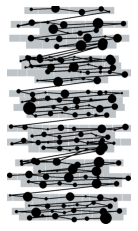

In [11]:
line_ys = correction.find_lines_Y(aois_with_tokens)

input_x = 520
input_y = 299

synth_fixations = correction.generate_fixations_lr_skip_regression(aois_with_tokens)
im = correction.fix_to_img_general('synthetic_text.png', synth_fixations, aois_with_tokens)
im_trim = correction.trim_image(im)
im_small = im_trim.resize((input_x, input_y))

plt.axis('off')
plt.imshow(np.asarray(im_trim))
plt.show()

In [12]:
# pick the optimal correction algorithm
good_algo = {
    0: "split",
    1: "merge",
    2: "warp",
    3: "cluster"
}

### Accuracy Comparison

In [13]:
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

In [14]:
attach_results = [[],[],[],[],[],[],[],[],[],[],[]]
chain_results = [[],[],[],[],[],[],[],[],[],[],[]]
cluster_results = [[],[],[],[],[],[],[],[],[],[],[]]
compare_results = [[],[],[],[],[],[],[],[],[],[],[]]
merge_results = [[],[],[],[],[],[],[],[],[],[],[]]
regress_results = [[],[],[],[],[],[],[],[],[],[],[]]
segment_results = [[],[],[],[],[],[],[],[],[],[],[]]
split_results = [[],[],[],[],[],[],[],[],[],[],[]]
stretch_results = [[],[],[],[],[],[],[],[],[],[],[]]
warp_results = [[],[],[],[],[],[],[],[],[],[],[]]
classifier_results = [[],[],[],[],[],[],[],[],[],[],[]]

# keep track of classifier prediction performance
prediction_results = [[],[],[],[],[],[],[],[],[],[],[]]

errors = [0,1,2,3]

for index in tqdm(range(30)):
    for error_type in errors:
        for error_probability in range(0, 11):
            # generate original trial
            synth_fixations = correction.generate_fixations_lr_skip_regression(aois_with_tokens)
            
            error_test = correction.add_random_error(
                error_type, 
                synth_fixations,
                error_probability
                )

            # attach correction
            np_array = np.array(error_test.copy())
            attach_correction = algo.attach(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, attach_correction)
            attach_results[error_probability].append(percentage)

            # chain correction
            np_array = np.array(error_test.copy())
            chain_correction = algo.chain(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, chain_correction)
            chain_results[error_probability].append(percentage)

            # cluster correction
            np_array = np.array(error_test.copy())
            cluster_correction = algo.cluster(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, cluster_correction)
            cluster_results[error_probability].append(percentage)

            # compare correction
            np_array = np.array(error_test.copy())
            compare_correction = algo.compare(np_array, duration_word_centers)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, compare_correction)
            compare_results[error_probability].append(percentage)

            # merge correction
            np_array = np.array(error_test.copy())
            merge_correction = algo.merge(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, merge_correction)
            merge_results[error_probability].append(percentage)
            
            # regress correction
            np_array = np.array(error_test.copy())
            regress_correction = algo.regress(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, regress_correction)
            regress_results[error_probability].append(percentage)

            # segment correction
            np_array = np.array(error_test.copy())
            segment_correction = algo.segment(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, segment_correction)
            segment_results[error_probability].append(percentage)
            
            # split correction
            np_array = np.array(error_test.copy())
            split_correction = algo.split(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, split_correction)
            split_results[error_probability].append(percentage)
            
            # stretch correction
            np_array = np.array(error_test.copy())
            stretch_correction = algo.stretch(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, stretch_correction)
            stretch_results[error_probability].append(percentage)
            
            # warp correction
            np_array = np.array(error_test.copy(), dtype=int)
            
            durations = np.delete(np_array, 0, 1)
            durations = np.delete(durations, 0, 1)
            np_array = np.delete(np_array, 2, 1)
            
            warp_correction = algo.warp(np_array, word_centers)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, warp_correction)
            warp_results[error_probability].append(percentage)

            # classify and then apply best correction
            np_array = np.array(error_test.copy())
            predicted_error = correction.predict_error(
                image, 
                np_array, 
                aois_with_tokens, 
                input_x, 
                input_y, 
                model)

            # print(f"error: {error_type}, Predicted: {predicted_error}")
            if error_probability == 0:
                prediction_results[error_probability].append(correction.validate_prediction(predicted_error, 4))
            else:
                prediction_results[error_probability].append(correction.validate_prediction(predicted_error, error_type))

            if predicted_error == 4: # no error case - do not correct
                percentage, match_list = correction.correction_quality (aoi, synth_fixations, np_array)
            
            else:
                this_correction = correction.apply_correction(
                    good_algo[predicted_error], 
                    np_array, 
                    line_ys, 
                    duration_word_centers, 
                    word_centers)
                percentage, match_list = correction.correction_quality (aoi, synth_fixations, this_correction)
            
            classifier_results[error_probability].append(percentage)
        


 17%|█▋        | 5/30 [1:10:04<5:51:14, 842.99s/it]C:\Users\PC\AppData\Local\Temp\ipykernel_9788\307487065.py:56: RankWarning: Polyfit may be poorly conditioned
  merge_correction = algo.merge(np_array, line_ys)
C:\Users\PC\AppData\Local\Temp\ipykernel_9788\307487065.py:56: RankWarning: Polyfit may be poorly conditioned
  merge_correction = algo.merge(np_array, line_ys)
C:\Users\PC\AppData\Local\Temp\ipykernel_9788\307487065.py:56: RankWarning: Polyfit may be poorly conditioned
  merge_correction = algo.merge(np_array, line_ys)
 37%|███▋      | 11/30 [2:33:40<4:25:14, 837.60s/it]C:\Users\PC\AppData\Local\Temp\ipykernel_9788\307487065.py:56: RankWarning: Polyfit may be poorly conditioned
  merge_correction = algo.merge(np_array, line_ys)
C:\Users\PC\AppData\Local\Temp\ipykernel_9788\307487065.py:56: RankWarning: Polyfit may be poorly conditioned
  merge_correction = algo.merge(np_array, line_ys)
C:\Users\PC\AppData\Local\Temp\ipykernel_9788\307487065.py:56: RankWarning: Polyfit may be p

In [15]:
import statistics

def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

In [16]:
mean_attach_results = mean_error_group(attach_results)
mean_chain_results = mean_error_group(chain_results)
mean_cluster_results = mean_error_group(cluster_results)
mean_compare_results = mean_error_group(compare_results)
mean_merge_results = mean_error_group(merge_results)
mean_regress_results = mean_error_group(regress_results)
mean_segment_results = mean_error_group(segment_results)
mean_split_results = mean_error_group(split_results)
mean_stretch_results = mean_error_group(stretch_results)
mean_warp_results = mean_error_group(warp_results)
mean_classifier_results = mean_error_group(classifier_results)
mean_prediction_results = mean_error_group(prediction_results)

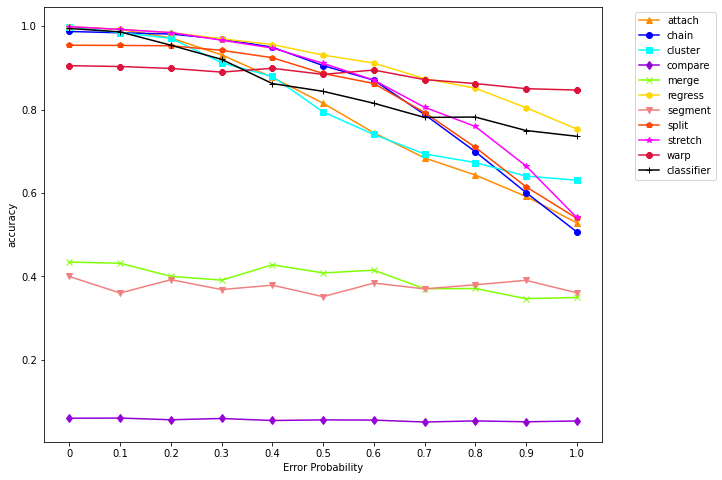

In [17]:
plt.figure(figsize=(10,8))

plt.plot(mean_attach_results, color='DarkOrange', marker='^')
plt.plot(mean_chain_results, color='Blue', marker='o')
plt.plot(mean_cluster_results, color='Aqua', marker='s')
plt.plot(mean_compare_results, color='DarkViolet', marker='d')
plt.plot(mean_merge_results, color='Chartreuse', marker='x')
plt.plot(mean_regress_results, color='Gold', marker='h')
plt.plot(mean_segment_results, color='lightcoral', marker='v')
plt.plot(mean_split_results, color='orangered', marker='p')
plt.plot(mean_stretch_results, color='magenta', marker='*')
plt.plot(mean_warp_results, color='crimson', marker='8')
plt.plot(mean_classifier_results, color='Black', marker='+')

plt.legend(
    ['attach', 'chain', 'cluster', 'compare', 'merge', 'regress', 'segment', 'split', 'stretch', 'warp', "classifier"], 
    bbox_to_anchor=(1.05, 1)
    )

plt.ylabel('accuracy')
plt.xlabel('Error Probability')

x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
plt.show()

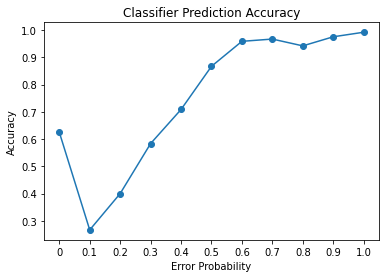

In [22]:
plt.plot(mean_prediction_results, marker='o')
x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.ylabel('Accuracy')
plt.xlabel('Error Probability')
plt.xticks(range(0, 11), x_ticks_labels)
plt.title("Classifier Prediction Accuracy")
plt.show()

In [23]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean cluster:", statistics.mean(mean_cluster_results))
print("mean compare:", statistics.mean(mean_compare_results))
print("mean merge:", statistics.mean(mean_merge_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean segment:", statistics.mean(mean_segment_results))
print("mean split:", statistics.mean(mean_split_results))
print("mean stretch:", statistics.mean(mean_stretch_results))
print("mean warp:", statistics.mean(mean_warp_results))
print("mean with classifier:", statistics.mean(mean_classifier_results))

mean attach: 0.7976635246683996
mean chain: 0.8420162213069858
mean cluster: 0.8150706490276495
mean compare: 0.05543950026166884
mean merge: 0.38385852707246104
mean regress: 0.9106939580334541
mean segment: 0.38349351527390585
mean split: 0.8306712826643712
mean stretch: 0.8547003864555315
mean warp: 0.8831400277837275
mean with classifier: 0.8588956044543189


 50%|█████     | 15/30 [3:28:24<3:31:04, 844.31s/it]C:\Users\PC\AppData\Local\Temp\ipykernel_9788\2091446099.py:55: RankWarning: Polyfit may be poorly conditioned
  merge_correction = algo.merge(np_array, line_ys)
100%|██████████| 30/30 [7:31:43<00:00, 903.44s/it]   


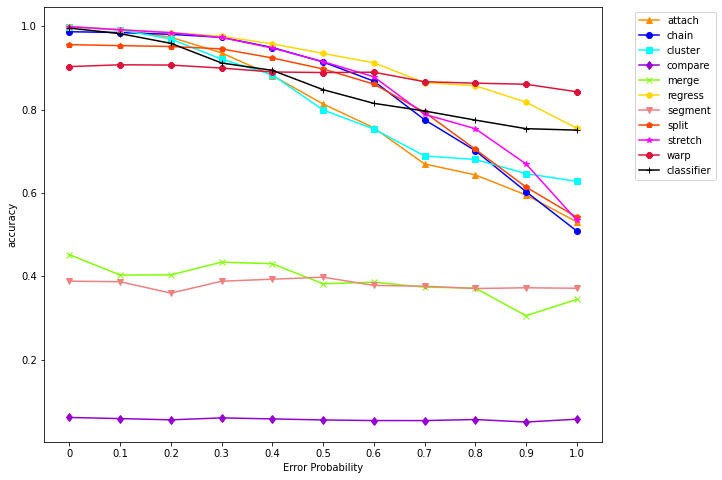

In [25]:
# when the predicted error is "no error", use chain

attach_results = [[],[],[],[],[],[],[],[],[],[],[]]
chain_results = [[],[],[],[],[],[],[],[],[],[],[]]
cluster_results = [[],[],[],[],[],[],[],[],[],[],[]]
compare_results = [[],[],[],[],[],[],[],[],[],[],[]] 
merge_results = [[],[],[],[],[],[],[],[],[],[],[]]
regress_results = [[],[],[],[],[],[],[],[],[],[],[]]
segment_results = [[],[],[],[],[],[],[],[],[],[],[]]
split_results = [[],[],[],[],[],[],[],[],[],[],[]]
stretch_results = [[],[],[],[],[],[],[],[],[],[],[]]
warp_results = [[],[],[],[],[],[],[],[],[],[],[]]
classifier_results = [[],[],[],[],[],[],[],[],[],[],[]]

errors = [0,1,2,3]

for index in tqdm(range(30)):
    for error_type in errors:
        for error_probability in range(0, 11):
            # generate original trial
            synth_fixations = correction.generate_fixations_lr_skip_regression(aois_with_tokens)
            
            error_test = correction.add_random_error(
                error_type, 
                synth_fixations,
                error_probability
                )

            # attach correction
            np_array = np.array(error_test.copy())
            attach_correction = algo.attach(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, attach_correction)
            attach_results[error_probability].append(percentage)

            # chain correction
            np_array = np.array(error_test.copy())
            chain_correction = algo.chain(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, chain_correction)
            chain_results[error_probability].append(percentage)

            # cluster correction
            np_array = np.array(error_test.copy())
            cluster_correction = algo.cluster(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, cluster_correction)
            cluster_results[error_probability].append(percentage)

            # compare correction
            np_array = np.array(error_test.copy())
            compare_correction = algo.compare(np_array, duration_word_centers)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, compare_correction)
            compare_results[error_probability].append(percentage)

            # merge correction
            np_array = np.array(error_test.copy())
            merge_correction = algo.merge(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, merge_correction)
            merge_results[error_probability].append(percentage)
            
            # regress correction
            np_array = np.array(error_test.copy())
            regress_correction = algo.regress(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, regress_correction)
            regress_results[error_probability].append(percentage)

            # segment correction
            np_array = np.array(error_test.copy())
            segment_correction = algo.segment(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, segment_correction)
            segment_results[error_probability].append(percentage)
            
            # split correction
            np_array = np.array(error_test.copy())
            split_correction = algo.split(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, split_correction)
            split_results[error_probability].append(percentage)
            
            # stretch correction
            np_array = np.array(error_test.copy())
            stretch_correction = algo.stretch(np_array, line_ys)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, stretch_correction)
            stretch_results[error_probability].append(percentage)
            
            # warp correction
            np_array = np.array(error_test.copy(), dtype=int)
            
            durations = np.delete(np_array, 0, 1)
            durations = np.delete(durations, 0, 1)
            np_array = np.delete(np_array, 2, 1)
            
            warp_correction = algo.warp(np_array, word_centers)
            percentage, match_list = correction.correction_quality(aoi, synth_fixations, warp_correction)
            warp_results[error_probability].append(percentage)

            # classify and then apply best correction
            np_array = np.array(error_test.copy())
            predicted_error = correction.predict_error(
                image, 
                np_array, 
                aois_with_tokens, 
                input_x, 
                input_y, 
                model)


            if predicted_error == 4: # no error case - use regress
                this_correction = correction.apply_correction(
                    "regress", 
                    np_array, 
                    line_ys, 
                    duration_word_centers, 
                    word_centers)
                percentage, match_list = correction.correction_quality (aoi, synth_fixations, this_correction)
            else:
                this_correction = correction.apply_correction(
                    good_algo[predicted_error], 
                    np_array, 
                    line_ys, 
                    duration_word_centers, 
                    word_centers)
                percentage, match_list = correction.correction_quality (aoi, synth_fixations, this_correction)
            
            classifier_results[error_probability].append(percentage)
        
mean_attach_results = mean_error_group(attach_results)
mean_chain_results = mean_error_group(chain_results)
mean_cluster_results = mean_error_group(cluster_results)
mean_compare_results = mean_error_group(compare_results)
mean_merge_results = mean_error_group(merge_results)
mean_regress_results = mean_error_group(regress_results)
mean_segment_results = mean_error_group(segment_results)
mean_split_results = mean_error_group(split_results)
mean_stretch_results = mean_error_group(stretch_results)
mean_warp_results = mean_error_group(warp_results)
mean_classifier_results = mean_error_group(classifier_results)

plt.figure(figsize=(10,8))

plt.plot(mean_attach_results, color='DarkOrange', marker='^')
plt.plot(mean_chain_results, color='Blue', marker='o')
plt.plot(mean_cluster_results, color='Aqua', marker='s')
plt.plot(mean_compare_results, color='DarkViolet', marker='d')
plt.plot(mean_merge_results, color='Chartreuse', marker='x')
plt.plot(mean_regress_results, color='Gold', marker='h')
plt.plot(mean_segment_results, color='lightcoral', marker='v')
plt.plot(mean_split_results, color='orangered', marker='p')
plt.plot(mean_stretch_results, color='magenta', marker='*')
plt.plot(mean_warp_results, color='crimson', marker='8')
plt.plot(mean_classifier_results, color='Black', marker='+')

plt.legend(
    ['attach', 'chain', 'cluster', 'compare', 'merge', 'regress', 'segment', 'split', 'stretch', 'warp', "classifier"], 
    bbox_to_anchor=(1.05, 1)
    )

plt.ylabel('accuracy')

plt.xlabel('Error Probability')

x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
plt.show()

In [ ]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean cluster:", statistics.mean(mean_cluster_results))
print("mean compare:", statistics.mean(mean_compare_results))
print("mean merge:", statistics.mean(mean_merge_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean segment:", statistics.mean(mean_segment_results))
print("mean split:", statistics.mean(mean_split_results))
print("mean stretch:", statistics.mean(mean_stretch_results))
print("mean warp:", statistics.mean(mean_warp_results))
print("mean with classifier:", statistics.mean(mean_classifier_results))

mean attach: 0.7976635246683996
mean chain: 0.8420162213069858
mean cluster: 0.8150706490276495
mean compare: 0.05543950026166884
mean merge: 0.38385852707246104
mean regress: 0.9106939580334541
mean segment: 0.38349351527390585
mean split: 0.8306712826643712
mean stretch: 0.8547003864555315
mean warp: 0.8831400277837275
mean with classifier: 0.8588956044543189
